In [1]:
# Import needed packages in PEP 8 order (no unused imports listed) (4 points total)

# Import required libraries here
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import folium
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry import Point
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep
import spectral.io.envi as envi
import spectral as spy
import tarfile
import zipfile
os.chdir(os.path.join(et.io.HOME,'earth-analytics'))

In [2]:
def open_ecosystem_structure(site, date):
    '''Uses API call to retrieve NEON ecosystem structure (CHM)
    data at a given site and date. Returns  list of all rasters
    within data product. For more information on NEON ecosystem 
    structure data and a full list of available dates see
    https://data.neonscience.org/data-products/DP3.30015.001
    
    Parameters
    ----------
    site : str
        4 Letter site name. See 
        https://www.neonscience.org/field-sites/field-sites-map/list
        for a full list of NEON sites
        
    date : str
        Date of data collection in yyyy-mm format
    
    Returns
    -------
    CHM_raster_tiles : .tif
        All raster .tif tiles associated with
        the site and date specified   
    '''
    data_product_url = ['https://data.neonscience.org/api/v0/data/DP3.30015.001/'
                        + site+'/'+date]
    call_response = requests.get(data_product_url[0])
    call_response.json()
    
    CHM_raster_tiles = []
    
    for i in call_response.json()['data']['files']:
        data_file_url = i['url']
        file_format = data_file_url.find('.tif')
        if not file_format == -1:
            CHM_raster_tiles.append(data_file_url)
    
    return CHM_raster_tiles

def high_res_imagery(site, date):
    '''Uses API call to retrieve NEON ecosystem structure (CHM)
    data at a given site and date. Returns  list of all rasters
    within data product. For more information on NEON ecosystem 
    structure data and a full list of available dates see
    https://data.neonscience.org/data-products/DP3.30010.001
    
    Parameters
    ----------
    site : str
        4 Letter site name. See 
        https://www.neonscience.org/field-sites/field-sites-map/list
        for a full list of NEON sites
        
    date : str
        Date of data collection in yyyy-mm format
    
    Returns
    -------
    CHM_raster_tiles : .tif
        All raster .tif tiles associated with
        the site and date specified   
    '''
    data_product_url = ['https://data.neonscience.org/api/v0/data/DP3.30010.001/'
                        + site+'/'+date]
    call_response = requests.get(data_product_url[0])
    call_response.json()
    
    high_res_raster_tiles = []
    
    for i in call_response.json()['data']['files']:
        data_file_url = i['url']
        file_format = data_file_url.find('.tif')
        if not file_format == -1:
            high_res_raster_tiles.append(data_file_url)
    
    return high_res_raster_tiles


def open_woody_veg_structure(site, date):
    '''Uses API call to retrieve NEON product data for woody 
    vegetation structure. Returns pandas of merged apparent 
    individual, mapping and tagging, and per plot per year
    documents, eg one dataframe with locational, species, 
    and height data. Also returns a pandas dataframe of filtered 
    plot data to facilitate geospatial merges and calculation of
    raster stats. For more information on NEON woody vegetation 
    structure data products and available dates, see
    https://data.neonscience.org/data-products/DP1.10098.001
    
    Parameters
    ----------
    site : str
        4 Letter site name. See 
        https://www.neonscience.org/field-sites/field-sites-map/list
        for a full list of NEON sites
    
    date : str
        Date of data collection in yyyy-mm format
    
    Returns
    -------
    all_merged_df : pandas.core.frame.DataFrame
        Pandas dataframe of merged measurement, plot, and mapping
        tabular files from data product
    
    plot_df : pandas.core.frame.DataFrame
        Pandas dataframe of perplotperyear.csv locational data
    '''
    data_product_url = ['https://data.neonscience.org/api/v0/data/DP1.10098.001/'
                        + site+'/'+date]
    call_response = requests.get(data_product_url[0])
    
    all_urls = []
    
    for i in call_response.json()['data']['files']:
        data_file_url = i['url']
        height_find = data_file_url.find('individual')
        plot_find = data_file_url.find('perplot')
        map_find = data_file_url.find('mapping')
        
        if not height_find == -1:
            apparent_df = pd.read_csv(data_file_url)
        elif not plot_find == -1:
            plot_df = pd.read_csv(data_file_url)
        elif not map_find == -1:
            map_df = pd.read_csv(data_file_url)
    
    apparent_df = apparent_df[[
        'plotID', 'individualID', 'height']]
    
    plot_df = plot_df[['plotID', 'plotType',
                       'decimalLatitude', 'decimalLongitude',
                       'easting', 'northing']]
    
    map_df = map_df[['plotID', 'individualID', 'scientificName']]
    
    measurement_map_merge = pd.merge(
        apparent_df, map_df, on=['plotID', 'individualID'])
    all_merged_df = pd.merge(plot_df, measurement_map_merge, on='plotID')
    
    return all_merged_df, plot_df


def NEON_site_extent(path_to_NEON_boundaries, site):
    '''Extracts a NEON site extent from an individual site as
    long as the original NEON site extent shape file contains 
    a column named 'siteID'.

    Parameters
    ----------
    path_to_NEON_boundaries : str
        The path to a shape file that contains the list
        of all NEON site extents, also known as field
        sampling boundaries (can be found at NEON and
        ESRI sites)

    site : str
        One siteID contains 4 capital letters, 
        e.g. CPER, HARV, ONAQ or SJER.

    Returns
    -------
    site_boundary : geopandas.geodataframe.GeoDataFrame
        A vector containing a single polygon 
        per the site specified.        
    '''
    NEON_boundaries = gpd.read_file(path_to_NEON_boundaries)
    boundaries_indexed = NEON_boundaries.set_index(['siteID'])

    site_boundary = boundaries_indexed.loc[[site]]
    site_boundary.reset_index(inplace=True)

    return site_boundary


def buffer_point_plots(df, crs, buffer):
    '''Creates geodataframe from plot points
    within a designated coordinate reference system. 
    Buffers plot points to a given radius. Compatible
    with most NEON tabular plot data files including
    northing and easting locational columns. Final product
    can be used to visualize plot locations or combined 
    with other spatial data products.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        df including Northing and Easting plot locations
    
    crs : str or rasterio.crs.CRS
        String of desired coordinate reference system
    
    buffer : int
        Desired radius for final plot polygons
    
    Returns
    -------
    buffered_gdf : geopandas.geodataframe.GeoDataFrame
       Dataframe with point plots buffered to polgyons
    '''
    buffered_gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(
            x=df.easting, y=df.northing), crs=crs)
    
    buffered_gdf['geometry'] = buffered_gdf.geometry.buffer(buffer)
    
    return(buffered_gdf)


def tiles_over_insitu_plots(tiles, plots):
    '''Takes a list of raster images and geodataframe
    of plot polygons within the same CRS. Cross references
    overlap between raster extent polygon and plot point 
    polygons. Returns list of .tiff file locations that 
    overlap completely with plot polygons.
    ----------
    tiles : list
        List of rasters
    
    plots : geopandas.geodataframe.GeoDataFrame
        Geodataframe with polygons of AOI plots
    
    Returns
    -------
    target_rasters : list
        List of strings with to raster locations
    '''
    target_rasters = []
    
    insitu_plot_size = plots.loc[0, 'geometry'].area
    
    for tile in tiles:
        with rio.open(tile) as src:
            extent = plotting_extent(src)
        raster_polygon = Polygon([
            [extent[0], extent[2]],
            [extent[0], extent[3]],
            [extent[1], extent[3]],
            [extent[1], extent[2]]])
        raster_polygon_gdf = gpd.GeoDataFrame(crs=src.crs,
                                              geometry=[raster_polygon])
        raster_plot_intersection = gpd.overlay(
            raster_polygon_gdf, plots, how='intersection')
        
        if raster_plot_intersection['geometry'].empty:
            pass
        elif int(
                raster_plot_intersection.loc[0, 'geometry'].area) == int(
                insitu_plot_size):
            target_rasters.append(tile)
    
    return target_rasters


def calculate_rasterstats_dataframe(tiles, plot_polygons):
    '''Creates a geodataframe object with lidar summary statistics 
    using rasterstats zonal. Requires a pandas dataframe with plot
    polygons to cross reference with lidar calculations. Outputs a
    single dataframe with uniquely named summary statistics.
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        df including Northing and Easting plot locations
    
    crs : str or rasterio.crs.CRS
        String of desired coordinate reference system or 
        rasterio CRS object
    
    Returns
    -------
    CHM_stats : list of geopandas.geodataframe.GeoDataFrame
        Returns a list of geodataframes with lidar max, lidar mean, 
        lidar median and lidar min calculated in new columns.
        calculations. 
    '''
    CHM_stats = []
    
    for tile in tiles:
        with rio.open(tile) as chm_src:
            site_chm = chm_src.read(1, masked=True)
            site_chm_meta = chm_src.meta
        site_tree_heights = rs.zonal_stats(
            plot_polygons,
            site_chm,
            affine=site_chm_meta["transform"],
            geojson_out=True,
            copy_properties=True,
            nodata=0,
            stats=["mean", "median", "max", "min"])
        site_tree_heights_gdf = gpd.GeoDataFrame.from_features(
            site_tree_heights)
    
    rename_dict_lidar = {"mean": "lidar_mean",
                         "median": "lidar_median",
                         "max": "lidar_max",
                         "min": "lidar_min"}

    site_tree_heights_gdf.rename(columns=rename_dict_lidar, inplace=True)
    CHM_stats.append(site_tree_heights_gdf)
    
    return CHM_stats

In [3]:
high_res_list=high_res_imagery('CPER','2017-05')

In [30]:
# Download shapefile of all NEON site boundaries
url = 'https://www.neonscience.org/neon-terrestrial-field-site-boundaries-shapefile'
et.data.get_data(url=url, replace=True)

# Create path to shapefile
terrestrial_sites = os.path.join(
    'data', 'earthpy-downloads',
    'fieldSamplingBoundaries (1)',
    'terrestrialSamplingBoundaries.shp')

# Import insitu plot data for CPER and ONAQ sites
CPER_insitu_df, CPER_plots = open_woody_veg_structure(
    site='CPER', date='2017-09')

# Import CHM data and identify crs
CPER_tif_files = open_ecosystem_structure(
    site='CPER', date='2017-05')
with rio.open(high_res_list[4]) as CPER_src:
    arr_dig=CPER_src.read(masked=True)
    CPER_crs = CPER_src.crs

# Create geodataframes with buffered plot points
CPER_insitu_gdf = buffer_point_plots(
    df=CPER_insitu_df, crs=CPER_crs, buffer=40)

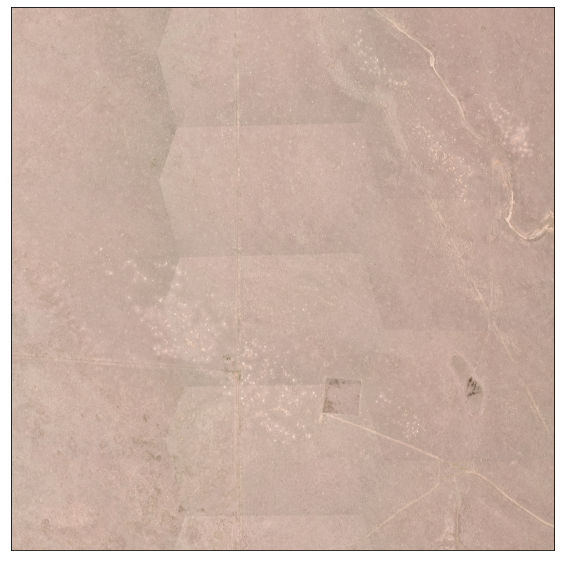

In [31]:
ep.plot_rgb(arr_dig,rgb=(0,1,2))

In [56]:
CPER_AOI_tifs = tiles_over_insitu_plots(
    tiles=high_res_list, plots=CPER_insitu_gdf)

In [67]:
with rio.open(CPER_AOI_tifs[1]) as src:
    arr=src.read(1,masked=True)
    extent=plotting_extent(src)

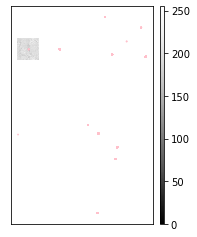

In [68]:
fig, ax = plt.subplots()
ep.plot_bands(arr,ax=ax,extent=extent)
CPER_insitu_gdf.plot(ax=ax,
                    color='pink')

In [40]:
tf_AVIRIS = tarfile.open(os.path.join('data','AVIRIS','f190821t01p00r12.tar.gz'))
tf_AVIRIS.extractall(path=os.path.join('AVIRIS'))
# tf_LANDSAT = tarfile.open(os.path.join(
#     ONAQ_directory,'LC08_L1TP_038032_20171010_20171024_01_T1.tar.gz'))
# tf_LANDSAT.extractall(path=LANDSAT_path)

In [32]:
# Download shapefile of all NEON site boundaries
url = 'https://www.neonscience.org/neon-terrestrial-field-site-boundaries-shapefile'
et.data.get_data(url=url, replace=True)

# Create path to shapefile
terrestrial_sites = os.path.join(
    'data', 'earthpy-downloads',
    'fieldSamplingBoundaries (1)',
    'terrestrialSamplingBoundaries.shp')
CPER_site_outline = NEON_site_extent(
    path_to_NEON_boundaries=terrestrial_sites,
    site='CPER')
CPER_site_outline.crs=AVIRIS_crs
CPER_site_outline.crs

<Projected CRS: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984", ...>
Name: unnamed
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
AVIRIS_path = os.path.join('AVIRIS', 'f170509t01p00r05rdn_e','f170509t01p00r05rdn_e_sc01_ort_img')
with rio.open (AVIRIS_path) as src:
    arr= src.read(masked=True)
    extent=plotting_extent(src)


MemoryError: Unable to allocate 2.56 GiB for an array with shape (224, 6954, 883) and data type int16

In [11]:
arr.shape

(224, 6954, 883)

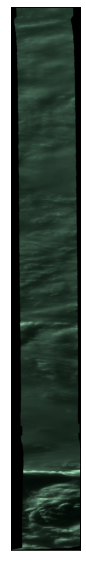

In [14]:
# fig, ax = plt.subplots()
ep.plot_rgb(arr, rgb=(40, 10, 20))
# CPER_insitu_gdf.plot(ax=ax,
#                     color='pink')



In [ ]:
# CPER_AOI_tifs = tiles_over_insitu_plots(
#     tiles=AVIRIS_path, plots=CPER_insitu_gdf)

with rio.open(AVIRIS_path) as chm_src:
    site_chm = chm_src.read(1, masked=True)
    site_chm_meta = chm_src.meta
site_tree_heights = rs.zonal_stats(
    CPER_insitu_gdf,
    site_chm,
    affine=site_chm_meta["transform"],
    geojson_out=True,
    copy_properties=True,
    nodata=0,
    stats=["mean", "median", "max", "min"])
site_tree_heights_gdf = gpd.GeoDataFrame.from_features(
    site_tree_heights)

In [ ]:
site_tree_heights_gdf